In [1]:
from pulp import *
import numpy as np

import networkx as nx
import osmnx as ox
import pandas as pd
from ast import literal_eval
import re
from time import time

np.random.seed(seed=42)

In [2]:
# columns = ['Periods','Retailers', 'Plants', 'Products', 'Vehicles', '# variables', '# constraints', 'Optimal solution (s)']
# experiment_results_df = pd.DataFrame(columns=columns)

# %store experiment_results_df
# %store -r experiment_results_df

# for col in experiment_results_df.columns[:-1]:
#     experiment_results_df[col] = experiment_results_df[col].map(int)

# experiment_results_df[experiment_results_df.columns[-1]] = experiment_results_df[experiment_results_df.columns[-1]].apply(lambda x: round(x, 2))

# Set hyperparameters

In [3]:
NUM_CAFES = 4
NUM_PERIODS = 2
NUM_PRODUCTS = 2
NUM_VEHICLES = 2
NUM_WAR = 1

# Denver data

In [4]:
# place = {'city'   : 'Denver',
#          'state'  : 'Colorado',
#          'country': 'USA'}
# G = ox.graph_from_place(place, network_type='drive', truncate_by_edge=True)

# %store G

In [5]:
%store -r G

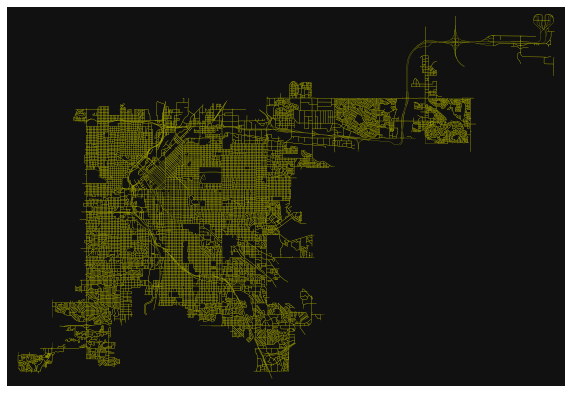

In [6]:
fig, ax = ox.plot_graph(G, figsize=(10, 10), node_size=0, edge_color='y', edge_linewidth=0.2)

In [7]:
# subway data pre-proccessed earlier
subway = pd.read_csv('https://raw.githubusercontent.com/olesyat/dataset_test/master/denver_subway.csv')

def get_city(address):
    return address['city']

subway['address'] = subway['address'].map(literal_eval)
subway['city'] = subway['address'].map(get_city)
subway['geo'] = subway['geo'].map(literal_eval)
subway['lat'] = subway['geo'].apply(lambda x: x['lat'])
subway['lon'] = subway['geo'].apply(lambda x: x['lon'])

In [8]:
subway_stores = [ox.get_nearest_node(G, (x[1].lat, x[1].lon)) for x in subway.iterrows()]
np.random.shuffle(subway_stores)
subway_stores = subway_stores[:NUM_CAFES]

nodes = list(set(G.nodes.keys())-set(subway_stores))

manufacturers = [nodes[np.random.randint(len(nodes))] for i in range(NUM_WAR)]

In [9]:
colors = ['r' if node in manufacturers else 'g' if node in subway_stores else 'w' for node in G.nodes.keys()]
sizes = [100 if node in manufacturers else 30 if node in subway_stores else 0 for node in G.nodes.keys()]

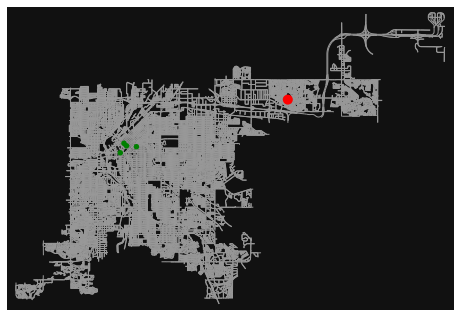

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [10]:
ox.plot_graph(G, node_color=colors, node_size=sizes)

In [11]:
stores = subway_stores.copy()
for manuf in manufacturers[:NUM_WAR]:
    stores.insert(0, manuf) # add warehouse as 0

In [12]:
distance_matrix = []
# time_matrix = []
path_matrix = []
for i in range(len(stores)):
    new_path = []
    new_distance = []
    new_time = []
    for j in range(len(stores)):
        try:
            length = nx.shortest_path_length(
                G, stores[i], stores[j], weight='length')
#             t = nx.shortest_path_length(
#                 G, stores[i], stores[j], weight='time')
            path = nx.shortest_path(
                G, stores[i], stores[j], weight='length')
            new_distance.append(length)
            new_path.append(path)
#             new_time.append(t)
        except:
            new_distance.append(np.inf)
            new_path.append(np.inf)
#             new_time.append(np.inf)
    path_matrix.append(new_path)
    distance_matrix.append(new_distance)
#     time_matrix.append(new_time)

cost = 0.62 # per liter NUMBEO
km_per_liter = 0.4
cost_per_km = cost*km_per_liter
routing_cost = cost_per_km * pd.DataFrame(distance_matrix)/1000

# Notations/Prerequisites

In [13]:
products = [f'product{i}' for i in range(NUM_PRODUCTS)] # n
locations = [f'cafe{i}' for i in range(NUM_CAFES)] # i
periods = [f'period{i}' for i in range(NUM_PERIODS)] # t
warehouses = [f'W{i}' for i in range(NUM_WAR)] # w
vehicles = [f'vehicle{i}' for i in range(NUM_VEHICLES)] # v

In [14]:
routing_cost = routing_cost.to_numpy()
routing_cost = np.vstack([routing_cost]*(len(periods))).reshape(len(periods), len(locations+warehouses), len(locations+warehouses))

# Parameters 

## Inventory

In [15]:
D_i_n_t = np.random.randint(30, 100, size=( len(periods), len(locations), len(products))) # demand
max_D = np.max(D_i_n_t)
mean_D = np.mean(D_i_n_t)
D_i_n_t = makeDict([periods, locations, products], D_i_n_t, 0)

N_n = np.random.randint(1, 3, size=(len(products))) # Product volume per 1 unit
max_N = np.max(N_n)
N_n = makeDict([products], N_n, 0)

S_i_n = abs(np.random.rand(len(locations), len(products))) # unit storage cost
S_i_n = makeDict([locations, products],S_i_n,0)

L_i_n = np.random.randint(mean_D//2, max_D, size=(len(locations), len(products))) # storage capacity at locations: maybe do same as with vehicles?
L_i_n = makeDict([locations, products], L_i_n, 0)

# perish periods for product
PP_n = np.random.randint(2, 5, size=(len(products))) # how many periods can a product go without going bad
PP_n = makeDict([products], PP_n, 0)

## Production

# TODO read numbeo

In [16]:
numbeo_df = pd.read_csv('https://raw.githubusercontent.com/olesyat/dataset_test/master/numbeo.csv')

In [17]:
# %store -r numbeo_df

In [18]:
numbeo_df['price'] = numbeo_df['price'].apply(lambda x: float(x.split()[0].replace(',', '')))

In [19]:
product_list = ['Domestic Beer (0.5 liter draught) ',
                'Imported Beer (0.33 liter bottle) ', 'Cappuccino (regular) ',
                'Coke/Pepsi (0.33 liter bottle) ', 'Water (0.33 liter bottle)  ',
                'Milk (regular), (1 liter) ', 'Loaf of Fresh White Bread (500g) ',
                'Rice (white), (1kg) ', 'Eggs (regular) (12) ',
                'Local Cheese (1kg) ', 'Chicken Fillets (1kg) ',
                'Beef Round (1kg) (or Equivalent Back Leg Red Meat) ',
                'Apples (1kg) ', 'Banana (1kg) ', 'Oranges (1kg) ',
                'Tomato (1kg) ', 'Potato (1kg) ', 'Onion (1kg) ',
                'Lettuce (1 head) ', 'Water (1.5 liter bottle) ',
                'Bottle of Wine (Mid-Range) ', 'Domestic Beer (0.5 liter bottle) ',
                'Imported Beer (0.33 liter bottle) ']

In [20]:
mean_price_onethrird = (numbeo_df[numbeo_df['product'].isin(product_list)]['price']/3).mean()
std_price_onethrird = (numbeo_df[numbeo_df['product'].isin(product_list)]['price']/3).std()

In [21]:
C_w_n_t = np.random.randint(1.5*NUM_CAFES*max_D, 3*NUM_CAFES*max_D, size=(len(periods), len(warehouses), len(products))) # production capacity per period (maybe consider hours, but can do without it, just estimate considering hours)
C_w_n_t = makeDict([periods, warehouses, products], C_w_n_t, 0)

Y_w_n = np.abs(mean_price_onethrird + std_price_onethrird*np.random.randn(len(warehouses), len(products))) # unit production cost
Y_w_n = makeDict([warehouses, products],Y_w_n,0)

# F_w_n = np.random.randint(500, 600, size=(len(warehouses), len(products))) # production fixed cost
# F_w_n = makeDict([warehouses, products], F_w_n, 0)

## Routing

In [22]:
T_i_j_t = makeDict([periods,warehouses+locations,warehouses+locations],routing_cost,0)

R_v = [NUM_PRODUCTS*max_N*NUM_CAFES*max_D//NUM_VEHICLES for i in range(len(vehicles))] # consider homogeneous case: each vehicle has the same capacity
R_v = makeDict([vehicles], R_v, 0)

# Variables

## Production

In [23]:
P_w_n_t = LpVariable.dicts("Production",(periods, warehouses,products),0,None,LpInteger) # production at w in period t of n

## Inventory

In [24]:
Perished_i_n_t_dummy = LpVariable.dicts("Dummy_Perished",(periods, locations,products),None,None,LpInteger)# amount perished
Perished_i_n_t = LpVariable.dicts("Perished",(periods, locations,products),0,None,LpInteger)# amount perished

B_i_n_t = LpVariable.dicts("b_dummy",(periods, locations,products),None,None,LpBinary) # dummy for max constraint

I_i_n_t = LpVariable.dicts("In.storage",(periods, locations,products),0,None,LpInteger)# amount left at location

## Routing

In [25]:
Z_t_i_v =  LpVariable.dicts("Location.visited",(periods, locations+warehouses, vehicles),0,None,LpBinary) # 1/0 if location/warehouse i visited by vehicle v in period t 

X_i_j_t_v = LpVariable.dicts("Arc.traversed",(periods, locations+warehouses, locations+warehouses, vehicles),0,None,LpBinary)  # 1/0 if route between traversed at time t for vehicle v

Q_i_n_t_v = LpVariable.dicts("Quantity.delivered",(periods, locations,vehicles, products),0,None,LpInteger) # quantity of n delivered to i at t

W_v_n_t = LpVariable.dicts("Load.vehicle",(periods, vehicles, products),0,None,LpInteger) # load of vehicle ?????????

U_t_i = LpVariable.dicts("Subtour.eliminated",(periods, locations),0,None,LpInteger) # dummy for elimination of subtours

# Objective function

In [26]:
model = LpProblem('Minimize_costs', LpMinimize)

In [27]:
tin = [(t, i, n) for t in periods for i in locations for n in products]
tijv = [(t, i, j, v) for t in periods for i in locations+warehouses for j in locations+warehouses for v in vehicles]
twn = [(t, w, n) for t in periods for w in warehouses for n in products]

In [28]:
model += lpSum([T_i_j_t[t][i][j]*X_i_j_t_v[t][i][j][v] for (t, i, j, v) in tijv]) + \
    lpSum([S_i_n[i][n]*I_i_n_t[t][i][n] for (t, i, n) in tin]) + \
    lpSum([ Y_w_n[w][n]*P_w_n_t[t][w][n]for t, w, n in twn]), 'Costs'

# Constratints

## Production

### 1: the production capacity is not exceeded

In [29]:
for t, w, n in twn:
    model += P_w_n_t[t][w][n] <= C_w_n_t[t][w][n]

### 2: Quantity delivered doesn't exceed production amount

In [30]:
iv = [(i, v) for i in locations for v in vehicles]

for t, n in [(t, n) for t in periods for n in products]:
    model += lpSum([Q_i_n_t_v[t][i][v][n] for i, v in iv]) <= lpSum([P_w_n_t[t][w][n] for w in warehouses]) 

## Inventory

### 3: Amount in storage does not exceed the storage capacity

In [31]:
for t, i, n in tin:
    model += I_i_n_t[t][i][n] <= L_i_n[i][n]

### 4: Amount in storage (t) = (t-1) delivered - demnad + stored  

In [32]:
for t_i, t in enumerate(periods):
    for i in locations:
        for n in products:
            if t == 'period0':
                model += I_i_n_t[t][i][n] == 0   
            else:
                t_1 = periods[t_i-1]
                model += I_i_n_t[t][i][n] == lpSum([Q_i_n_t_v[t_1][i][v][n] for v in vehicles]) - D_i_n_t[t_1][i][n] + I_i_n_t[t_1][i][n] - Perished_i_n_t[t][i][n] 

### 5: Product saved for N periods is thrown away. (without penalty)

In [33]:
for t_i, t in enumerate(periods):
    for i in locations:
        for n in products:
            going_bad = PP_n[n]
            if t_i < going_bad: # no product can be perished before its perish date
                model += Perished_i_n_t[t][i][n] == 0
            else:
                temp = (lpSum(Q_i_n_t_v[periods[t_i-going_bad]][i][v][n] for v in vehicles) - lpSum( D_i_n_t[periods[t_i-gb]][i][n] for gb in range(t_i,0, -1)))
                
                model += Perished_i_n_t_dummy[t][i][n] == temp
                
                model += Perished_i_n_t[t][i][n] >= Perished_i_n_t_dummy[t][i][n]
                model += Perished_i_n_t[t][i][n] >= 0
                
                M = 1000
                model += Perished_i_n_t[t][i][n] <= Perished_i_n_t_dummy[t][i][n] + M*B_i_n_t[t][i][n]
                model += Perished_i_n_t[t][i][n] <= 0 + M*(1-B_i_n_t[t][i][n])

### 6:  (storage period) amout in storage + delivered exceeds the demand

In [34]:
for t, i, n in tin:
    model += I_i_n_t[t][i][n] + \
        lpSum([Q_i_n_t_v[t][i][v][n] for v in vehicles]) >= D_i_n_t[t][i][n]

## Routing

### 7: Load of vehicle is not exceeded

In [35]:
# capacity of vehicle is not exceeded
tv = [(t, v) for t in periods for v in vehicles]

for t, v in tv:
    model += lpSum([N_n[n]*W_v_n_t[t][v][n] for n in products]) <= R_v[v]

### 8: load of vehicle does not exceed the produced amount

In [36]:
tn = [(t, n) for t in periods for n in products]
for t, n in tn:
    model += lpSum([W_v_n_t[t][v][n] for v in vehicles]) <= lpSum([P_w_n_t[t][w][n] for w in warehouses])

### 9: quantity delivered does not exceed the vehicle load


In [37]:
# load of vehicle constraints
# quantity delivered does not exceed the vehicle load
tvn = [(t, v, n) for t in periods for v in vehicles for n in products]
for t, v, n in tvn:
    model += ([Q_i_n_t_v[t][i][v][n] for i in locations]) <= W_v_n_t[t][v][n]

### 10: quantity delivered is not 0 only if LOCATION VISITED (route exists)

In [38]:
# quantity delivered is not 0 only if LOCATION VISITED (route exists)
# quantity delivered is less than the availible space

tinv = [(t, i, n, v) for t in periods for i in locations for n in products for v in vehicles]
for t, i, n, v in tinv:
    model += Q_i_n_t_v[t][i][v][n] <= Z_t_i_v[t][i][v] * (L_i_n[i][n] + D_i_n_t[t][i][n])

### 11: quantity loaded only if warehouse visited

In [39]:
for t, v, n in tvn:
    model += W_v_n_t[t][v][n] <= lpSum([Z_t_i_v[t][w][v] * C_w_n_t[t][w][n] for w in warehouses])

### 12: no route between same locations

In [40]:
tv = [(t, v) for t in periods for v in vehicles]
for i in locations+warehouses:
    for j in locations+warehouses:
        if i == j:
            model += lpSum([X_i_j_t_v[t][i][j][v] for (t, v) in tv]) == 0

### 13: Flow constraints

In [41]:
tvi = [(t, v, i) for t in periods for v in vehicles for i in locations+warehouses]
for t, v, i in tvi:
    model += lpSum([X_i_j_t_v[t][i][j][v] for j in locations+warehouses]) == Z_t_i_v[t][i][v]

### 14: if vehicle arrived at i it must leave from it

In [42]:
for t, v, i in tvi:
    model += lpSum([X_i_j_t_v[t][j][i][v] for j in locations+warehouses]) == lpSum([X_i_j_t_v[t][i][l][v] for l in locations+warehouses])

### 15 start and end at warehouse

In [43]:
twv = [(t, w, v) for t in periods for w in warehouses for v in vehicles]
for t, w, v in twv:
    model += lpSum([X_i_j_t_v[t][w][j][v] for j in locations+warehouses]) == lpSum([X_i_j_t_v[t][i][w][v] for i in locations])

### 16: Subtour elimination

In [44]:
n = len(locations)
m = len(warehouses)

tij = [(t, i, j) for t in periods for i in locations for j in locations]
for t, i, j in tij:
    model += U_t_i[t][j] >= U_t_i[t][i] + 1 - (n+m)*(1 - lpSum([X_i_j_t_v[t][i][j][v] for v in vehicles]))

# Solve

In [45]:
start_time = time()
model.solve()
end_time = time() - start_time
# experiment_results_df.loc[len(experiment_results_df)] = [NUM_PERIODS, NUM_CAFES, NUM_WAR, NUM_PRODUCTS, NUM_VEHICLES,  model.numVariables(), model.numConstraints(), end_time]


print("Status:", LpStatus[model.status])
print('Solver:', model.solver)

print("Total Cost  = ", value(model.objective))

Status: Optimal
Solver: <pulp.apis.coin_api.PULP_CBC_CMD object at 0x000002AF2E1D0820>
Total Cost  =  3343.1177859873983


In [46]:
model.numConstraints(), model.numVariables(), model.isMIP()

(209, 204, 1)

In [47]:
for v in model.variables():
    print(v.name, "=", v.varValue)

Arc.traversed_period0_W0_W0_vehicle0 = 0.0
Arc.traversed_period0_W0_W0_vehicle1 = 0.0
Arc.traversed_period0_W0_cafe0_vehicle0 = 0.0
Arc.traversed_period0_W0_cafe0_vehicle1 = 0.0
Arc.traversed_period0_W0_cafe1_vehicle0 = 1.0
Arc.traversed_period0_W0_cafe1_vehicle1 = 0.0
Arc.traversed_period0_W0_cafe2_vehicle0 = 0.0
Arc.traversed_period0_W0_cafe2_vehicle1 = 0.0
Arc.traversed_period0_W0_cafe3_vehicle0 = 0.0
Arc.traversed_period0_W0_cafe3_vehicle1 = 1.0
Arc.traversed_period0_cafe0_W0_vehicle0 = 0.0
Arc.traversed_period0_cafe0_W0_vehicle1 = 0.0
Arc.traversed_period0_cafe0_cafe0_vehicle0 = 0.0
Arc.traversed_period0_cafe0_cafe0_vehicle1 = 0.0
Arc.traversed_period0_cafe0_cafe1_vehicle0 = 0.0
Arc.traversed_period0_cafe0_cafe1_vehicle1 = 0.0
Arc.traversed_period0_cafe0_cafe2_vehicle0 = 1.0
Arc.traversed_period0_cafe0_cafe2_vehicle1 = 0.0
Arc.traversed_period0_cafe0_cafe3_vehicle0 = 0.0
Arc.traversed_period0_cafe0_cafe3_vehicle1 = 0.0
Arc.traversed_period0_cafe1_W0_vehicle0 = 0.0
Arc.traversed_pe

In [48]:
# %store experiment_results_df
# experiment_results_df

# Check

In [49]:
In_storage = pd.DataFrame(columns=['period', 'location', 'product', 'value'])
Load_vehicle = pd.DataFrame(columns=['period', 'vehicle', 'product', 'value'])
Production = pd.DataFrame(columns=['period', 'warehouse', 'product', 'value'])
Quantity_delivered = pd.DataFrame(columns=['period', 'location', 'vehicle', 'product', 'value'])
Arc_traversed = pd.DataFrame(columns=['period', 'location1', 'location2', 'vehicle', 'value'])
Location_visited = pd.DataFrame(columns=['period', 'location', 'vehicle', 'value'])
Perished = pd.DataFrame(columns=['period', 'location', 'product', 'value'])
Subtour_eliminated = pd.DataFrame()

check_dict = {'In.storage': In_storage,
             'Load.vehicle': Load_vehicle,
             'Production': Production,
             'Quantity.delivered': Quantity_delivered,
             'Arc.traversed': Arc_traversed, 
             'Location.visited': Location_visited,
              'Perished': Perished,
             'Subtour.eliminated': Subtour_eliminated}

In [50]:
frames = []
for v in model.variables():
    splited_name = v.name.split('_')
    if splited_name[0] in ['b', 'Dummy']:
        continue
    temp_df = check_dict[splited_name[0]]
    if splited_name[0] in ['Arc.traversed', 'Quantity.delivered']:
        t1 =  splited_name[1]
        t2 = splited_name[2]
        t3 = splited_name[3]
        t4 = splited_name[4]
        temp_df.loc[len(temp_df)] = [t1, t2, t3, t4, v.varValue]
    elif splited_name[0] == 'Subtour.eliminated':
        pass
    else:
        t1 =  splited_name[1]
        t2 = splited_name[2]
        t3 = splited_name[3]
        temp_df.loc[len(temp_df)] = [t1, t2, t3, v.varValue] 

# Validation

In [51]:
D_i_n_t

defaultdict(<function pulp.utilities.__makeDict.<locals>.<lambda>()>,
            {'period0': defaultdict(<function pulp.utilities.__makeDict.<locals>.<lambda>()>,
                         {'cafe0': defaultdict(<function pulp.utilities.__makeDict.<locals>.<lambda>()>,
                                      {'product0': 32, 'product1': 51}),
                          'cafe1': defaultdict(<function pulp.utilities.__makeDict.<locals>.<lambda>()>,
                                      {'product0': 82, 'product1': 31}),
                          'cafe2': defaultdict(<function pulp.utilities.__makeDict.<locals>.<lambda>()>,
                                      {'product0': 59, 'product1': 67}),
                          'cafe3': defaultdict(<function pulp.utilities.__makeDict.<locals>.<lambda>()>,
                                      {'product0': 31, 'product1': 93})}),
             'period1': defaultdict(<function pulp.utilities.__makeDict.<locals>.<lambda>()>,
                         {'c

In [52]:
Production

,period,warehouse,product,value
0,period0,W0,product0,204.0
1,period0,W0,product1,242.0
2,period1,W0,product0,290.0
3,period1,W0,product1,286.0


In [53]:
Quantity_delivered[Quantity_delivered.period == 'period0']

,period,location,vehicle,product,value
0,period0,cafe0,vehicle0,product0,32.0
1,period0,cafe0,vehicle0,product1,51.0
2,period0,cafe0,vehicle1,product0,0.0
3,period0,cafe0,vehicle1,product1,0.0
4,period0,cafe1,vehicle0,product0,82.0
5,period0,cafe1,vehicle0,product1,31.0
6,period0,cafe1,vehicle1,product0,0.0
7,period0,cafe1,vehicle1,product1,0.0
8,period0,cafe2,vehicle0,product0,59.0
9,period0,cafe2,vehicle0,product1,67.0


In [54]:
# check_dict['Arc.traversed'][(check_dict['Arc.traversed'].period == 'period0')
#                            & (check_dict['Arc.traversed'].vehicle == 'vehicle0')].pivot_table(index='location1',
#                                                                                  columns='location2', 
#                                                                                  values='value', 
#                                                                                  aggfunc = sum)